## Precipitation extremes

In [17]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import spatial_selection
import plotting

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
dask.diagnostics.ProgressBar().register()

In [20]:
start_date = '1980-01-01'
end_date = '1989-12-31'

In [21]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [22]:
def read_data(infile, regrid=False, time_bounds=None):
    """Read data and calculate annual mean.
    
    Parameters
    ----------
    infile (str)
    regrid (xarray Dataset) - grid to remap to
    time_bounds (list)
    
    """
    
    ds = xr.open_dataset(infile, decode_timedelta=False)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    annual_mean = ds.mean('time', keep_attrs=True)
    if type(regrid) == xr.core.dataset.Dataset:
        regridder = xe.Regridder(ds, regrid, "bilinear")
        annual_mean = regridder(annual_mean)    
    annual_mean = spatial_selection.select_shapefile_regions(annual_mean, aus_shape)    
    annual_mean = annual_mean.compute()
    
    return annual_mean

In [23]:
def plot_index(var_name, index_name, data_levels, diff_levels):
    """Plot a climate index"""

    index_name_lower = index_name.lower()
    infiles = {}
    infiles['AGCD'] = f'/g/data/xv83/dbi599/indices/{index_name_lower}_year_AGCD_v1_r005_1900-2021.nc'
    infiles['ACCESS-CM2'] = f'/g/data/xv83/dbi599/indices/{index_name_lower}_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc'
    infiles['BARPA'] = f'/g/data/xv83/dbi599/indices/{index_name_lower}_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc'

    annual_mean = {}
    annual_mean['AGCD'] = read_data(
        infiles['AGCD'], regrid=False, time_bounds=[start_date, end_date]
    )

    for model in ['ACCESS-CM2', 'BARPA']:
        annual_mean[model] = read_data(
            infiles[model], regrid=annual_mean['AGCD'], time_bounds=[start_date, end_date]
        )

    plotting.compare_agcd_gcm_rcm(
        annual_mean['AGCD'][index_name],
        annual_mean['ACCESS-CM2'][index_name],
        var_name,
        index_name_lower,
        'ACCESS-CM2',
        'BARPA',
        start_date,
        end_date,
        data_levels,
        diff_levels,
        rcm_da=annual_mean['BARPA'][index_name],
)

## rx1day

/g/data/xv83/dbi599/model-evaluation/pr_rx1day_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


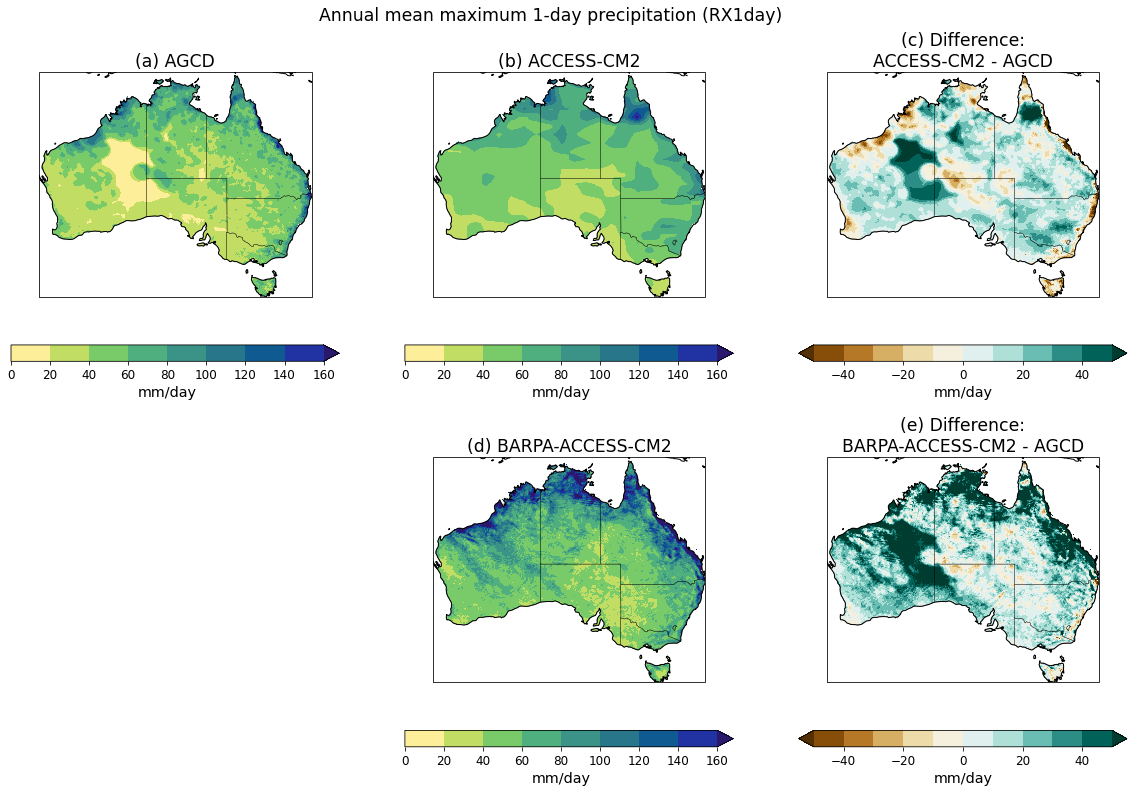

In [24]:
plot_index(
    'pr',
    'RX1day',
    [0, 20, 40, 60, 80, 100, 120, 140, 160],
    [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50],
)

## r95ptot - Annual total precipitation from heavy rain (rainfall rate > 95th percentile)


/g/data/xv83/dbi599/model-evaluation/pr_r95ptot_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


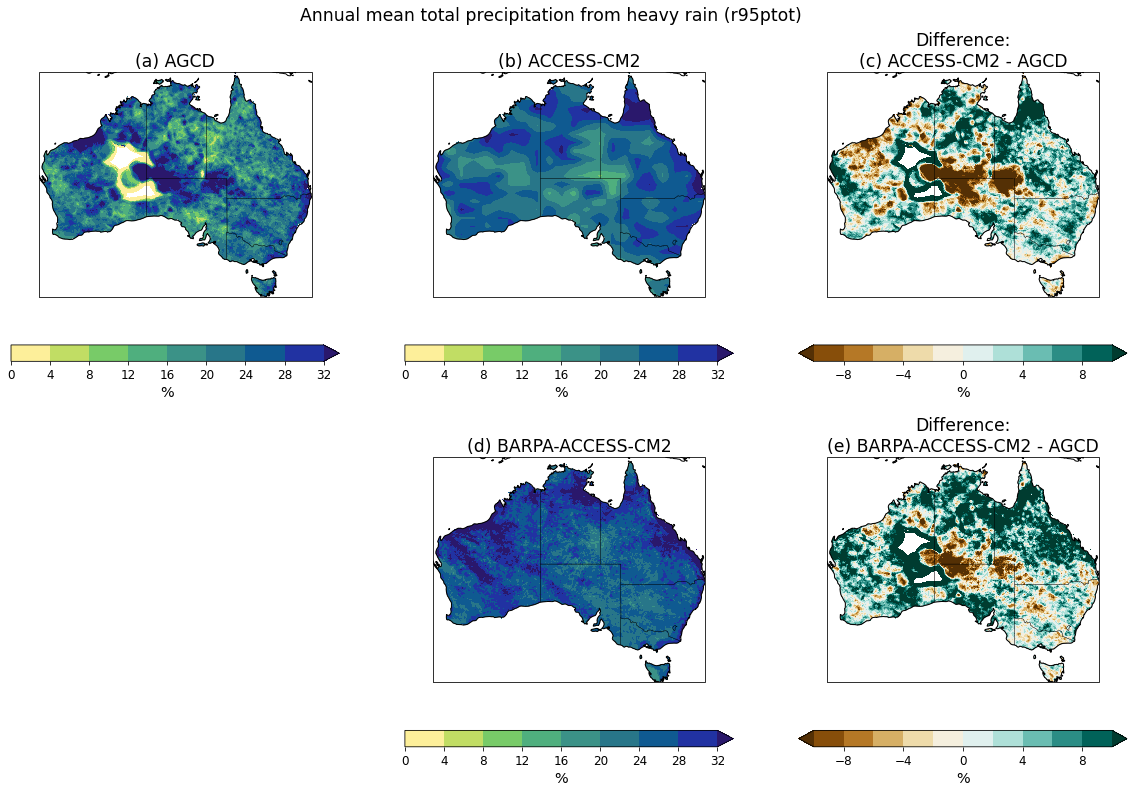

In [25]:
plot_index(
    'pr',
    'R95pTOT',
    [0, 4, 8, 12, 16, 20, 24, 28, 32],
    [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10],
)

## r10mm - Number of heavy precipitation days (>10mm)

/g/data/xv83/dbi599/model-evaluation/pr_r10mm_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


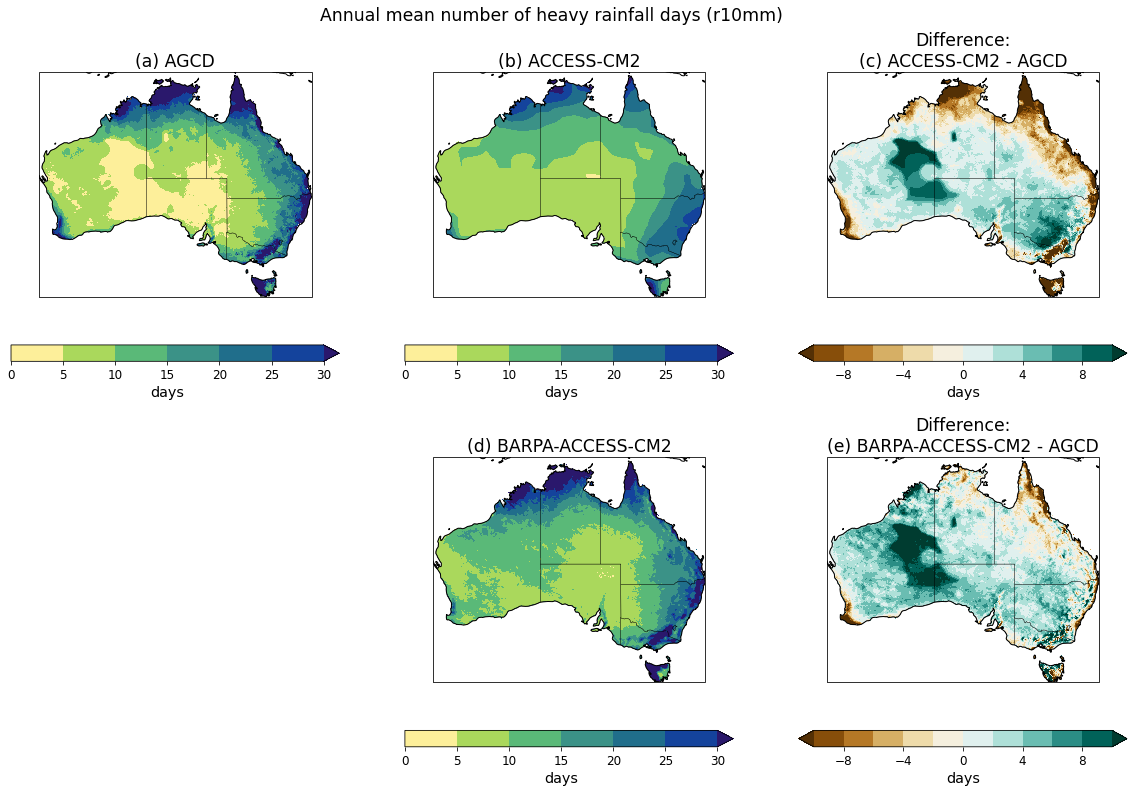

In [26]:
plot_index(
    'pr',
    'R10mm',
    [0, 5, 10, 15, 20, 25, 30],
    [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10],
)

## CDD - Maximum consecutive dry days (< 1mm)

/g/data/xv83/dbi599/model-evaluation/pr_cdd_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


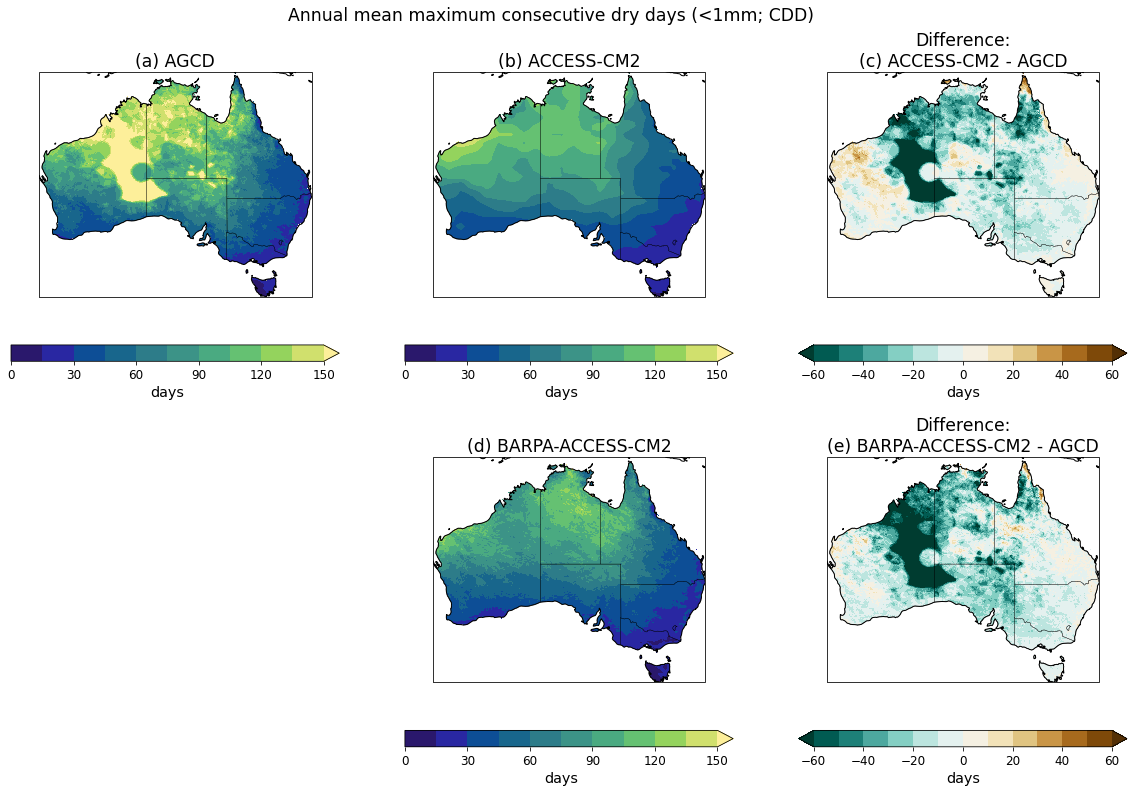

In [28]:
plot_index(
    'pr',
    'CDD',
    [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150],
    [-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60],
)

## CWD - Maximum consecutive wet days (>1mm)

/g/data/xv83/dbi599/model-evaluation/pr_cwd_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


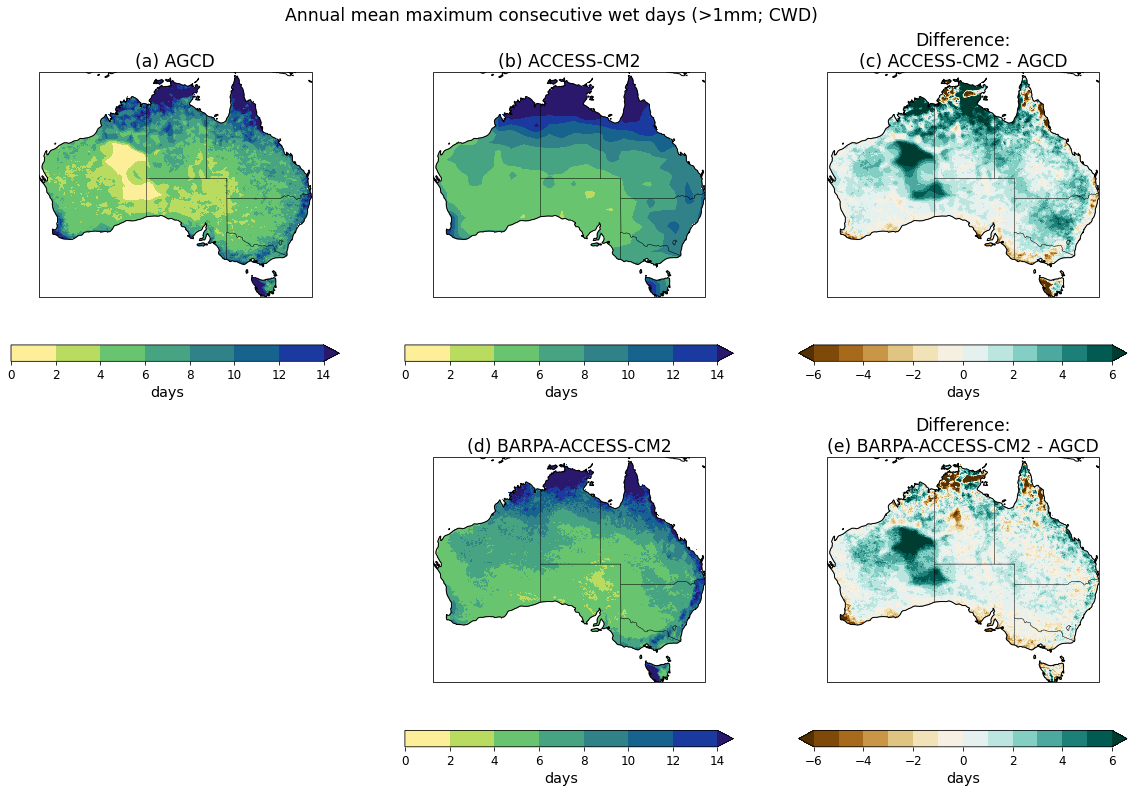

In [29]:
plot_index(
    'pr',
    'CWD',
    [0, 2, 4, 6, 8, 10, 12, 14],
    [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6],
)